# Cluster by accessory gene expression

This notebook is visualizing the expression of accessory genes in the PAO1 and PA14 compendia

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import plotnine as pn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import umap
from sklearn.decomposition import PCA
import utils

/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Load data

In [2]:
# Expression data files
pao1_expression_filename = "../qc_filtering/qc-out/pao1_aligned_compendium_p2_filtered_counts_norm.csv"
pa14_expression_filename = "../qc_filtering/qc-out/pa14_aligned_compendium_p2_filtered_counts_norm.csv"

# File containing table to map sample id to strain name
sample_to_strain_filename = "Run_Table_Strain_Bool_GD.csv"

In [3]:
# Load expression data
# Matrices will be sample x gene after taking the transpose
pao1_expression = pd.read_csv(pao1_expression_filename, index_col=0, header=0).T
pa14_expression = pd.read_csv(pa14_expression_filename, index_col=0, header=0).T

In [4]:
print(pao1_expression.shape)
pao1_expression.head()

(2588, 5563)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571.ERX541571.salmon,5589.915138,897.177641,1373.180223,1801.831763,139.560966,505.908503,480.986902,662.914591,677.867551,77.256964,...,0.0,97.194244,468.526102,12.460801,87.225604,74.764803,77.256964,2275.342185,249.216012,0.000000
ERX541572.ERX541572.salmon,6297.494504,831.965260,1747.273260,1807.221548,190.079936,416.713706,320.211585,491.283528,663.817624,45.326754,...,0.0,80.418435,485.434914,10.235073,70.183361,46.788907,59.948288,2209.313721,198.852856,0.000000
ERX541573.ERX541573.salmon,4948.395849,892.785667,1982.509348,1750.122490,350.549666,362.365947,372.869308,464.773715,615.759526,42.013443,...,0.0,114.224049,781.187458,19.693801,153.611651,43.326363,106.346528,1473.096350,101.094848,0.000000
ERX541574.ERX541574.salmon,4633.161907,778.582016,2242.316207,1923.696490,313.828444,325.806628,438.401566,438.401566,510.270675,79.056020,...,0.0,153.320766,565.370326,21.560733,86.242931,38.330192,64.682198,2129.721269,79.056020,2.395637
ERX541575.ERX541575.salmon,4228.807727,868.906226,2124.210932,1775.079310,317.749004,286.366386,274.597904,572.732772,733.568687,56.880994,...,0.0,135.337539,672.764866,15.691309,194.179947,21.575550,117.684816,1637.780358,60.803822,0.000000


In [5]:
print(pa14_expression.shape)
pa14_expression.head()

(2588, 5891)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX541571.ERX541571.salmon,211.451625,56.208660,0.000000,2.676603,10.706411,10.706411,18.736220,72.268277,66.915071,5.353206,...,42.825646,141.859951,3522.409344,182.008993,21.412823,2.676603,1025.138890,390.784015,152.566362,0.0
ERX541572.ERX541572.salmon,221.780416,51.647494,6.076176,15.190439,21.266615,9.114264,12.152352,78.990285,82.028373,3.038088,...,60.761758,179.247186,2953.021435,221.780416,27.342791,15.190439,1193.968543,568.122437,118.485428,0.0
ERX541573.ERX541573.salmon,168.134943,44.835985,18.214619,23.819117,8.406747,18.214619,5.604498,64.451728,57.446106,8.406747,...,56.044981,208.767554,1820.060757,68.655102,4.203374,12.610121,1548.242600,619.297040,63.050604,0.0
ERX541574.ERX541574.salmon,203.805778,13.505202,6.138728,14.732948,4.910983,17.188439,8.594220,47.882080,58.931791,7.366474,...,67.526011,227.132945,2248.002282,77.347976,6.138728,12.277456,1706.566451,898.709814,165.745663,0.0
ERX541575.ERX541575.salmon,193.980790,46.386711,8.433947,29.518816,8.433947,12.650921,4.216974,44.278224,42.169737,6.325461,...,40.061250,250.909936,1575.039679,65.363092,4.216974,10.542434,1313.587310,710.560070,145.485593,0.0


In [6]:
# Load metadata
# Set index to experiment id, which is what we will use to map to expression data
sample_to_strain_table_full = pd.read_csv(sample_to_strain_filename, index_col=2)
sample_to_strain_table_full.head()

,Unnamed: 0,Run,Sample.Name,SRA_study,BioProject,GEO_Accession..exp.,source_name,Strain,PAO1,PA14,PAK,ClinicalIsolate
Experiment,,,,,,,,,,,,
SRX5057740,1,SRR8239475,CLJ1,SRP170343,PRJNA383797,NaN,NaN,CLJ1,False,False,False,False
SRX5057739,2,SRR8239476,CLJ1,SRP170343,PRJNA383797,NaN,NaN,CLJ1,False,False,False,False
SRX5057910,3,SRR8239645,CLJ3,SRP170410,PRJNA383798,NaN,NaN,CLJ3,False,False,False,False
SRX5057909,4,SRR8239646,CLJ3,SRP170410,PRJNA383798,NaN,NaN,CLJ3,False,False,False,False
SRX3573046,5,SRR6483189,PAO1 samples from Colistin/Doripenem treatment,SRP130183,PRJNA414673,NaN,NaN,PAO1,True,False,False,False


## Process data

In [7]:
# Format expression data indices so that values can be mapped to `sample_to_strain_table`
pao1_index_processed = pao1_expression.index.str.split(".").str[0]
pa14_index_processed = pa14_expression.index.str.split(".").str[0]

pao1_expression.index = pao1_index_processed
pa14_expression.index = pa14_index_processed

In [8]:
pao1_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571,5589.915138,897.177641,1373.180223,1801.831763,139.560966,505.908503,480.986902,662.914591,677.867551,77.256964,...,0.0,97.194244,468.526102,12.460801,87.225604,74.764803,77.256964,2275.342185,249.216012,0.000000
ERX541572,6297.494504,831.965260,1747.273260,1807.221548,190.079936,416.713706,320.211585,491.283528,663.817624,45.326754,...,0.0,80.418435,485.434914,10.235073,70.183361,46.788907,59.948288,2209.313721,198.852856,0.000000
ERX541573,4948.395849,892.785667,1982.509348,1750.122490,350.549666,362.365947,372.869308,464.773715,615.759526,42.013443,...,0.0,114.224049,781.187458,19.693801,153.611651,43.326363,106.346528,1473.096350,101.094848,0.000000
ERX541574,4633.161907,778.582016,2242.316207,1923.696490,313.828444,325.806628,438.401566,438.401566,510.270675,79.056020,...,0.0,153.320766,565.370326,21.560733,86.242931,38.330192,64.682198,2129.721269,79.056020,2.395637
ERX541575,4228.807727,868.906226,2124.210932,1775.079310,317.749004,286.366386,274.597904,572.732772,733.568687,56.880994,...,0.0,135.337539,672.764866,15.691309,194.179947,21.575550,117.684816,1637.780358,60.803822,0.000000


In [9]:
pa14_expression.head()

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX541571,211.451625,56.208660,0.000000,2.676603,10.706411,10.706411,18.736220,72.268277,66.915071,5.353206,...,42.825646,141.859951,3522.409344,182.008993,21.412823,2.676603,1025.138890,390.784015,152.566362,0.0
ERX541572,221.780416,51.647494,6.076176,15.190439,21.266615,9.114264,12.152352,78.990285,82.028373,3.038088,...,60.761758,179.247186,2953.021435,221.780416,27.342791,15.190439,1193.968543,568.122437,118.485428,0.0
ERX541573,168.134943,44.835985,18.214619,23.819117,8.406747,18.214619,5.604498,64.451728,57.446106,8.406747,...,56.044981,208.767554,1820.060757,68.655102,4.203374,12.610121,1548.242600,619.297040,63.050604,0.0
ERX541574,203.805778,13.505202,6.138728,14.732948,4.910983,17.188439,8.594220,47.882080,58.931791,7.366474,...,67.526011,227.132945,2248.002282,77.347976,6.138728,12.277456,1706.566451,898.709814,165.745663,0.0
ERX541575,193.980790,46.386711,8.433947,29.518816,8.433947,12.650921,4.216974,44.278224,42.169737,6.325461,...,40.061250,250.909936,1575.039679,65.363092,4.216974,10.542434,1313.587310,710.560070,145.485593,0.0


In [10]:
# Aggregate boolean labels into a single strain label
aggregated_label = []
for exp_id in list(sample_to_strain_table_full.index):
    if sample_to_strain_table_full.loc[exp_id, "PAO1"].all() == True:
        aggregated_label.append("PAO1")
    elif sample_to_strain_table_full.loc[exp_id, "PA14"].all() == True:
        aggregated_label.append("PA14")
    elif sample_to_strain_table_full.loc[exp_id, "PAK"].all() == True:
        aggregated_label.append("PAK")
    elif sample_to_strain_table_full.loc[exp_id, "ClinicalIsolate"].all() == True:
        aggregated_label.append("Clinical Isolate")
    else:
        aggregated_label.append("NA")

sample_to_strain_table_full["Strain type"] = aggregated_label

sample_to_strain_table = sample_to_strain_table_full["Strain type"].to_frame()

In [11]:
sample_to_strain_table.head()

,Strain type
Experiment,
SRX5057740,NA
SRX5057739,NA
SRX5057910,NA
SRX5057909,NA
SRX3573046,PAO1


In [12]:
# What are the NA strains?
print(sample_to_strain_table.shape)
sample_to_strain_table["Strain type"].value_counts()

(3013, 1)


PAO1                911
NA                  831
Clinical Isolate    618
PA14                588
PAK                  65
Name: Strain type, dtype: int64

In [13]:
# Most of these strains don't have strain annotation available
na_sample_ids = list(
    sample_to_strain_table[sample_to_strain_table["Strain type"] == "NA"].index
)
sample_to_strain_table_full.loc[na_sample_ids, "Strain"].isnull().sum()

579

In [14]:
# Use to manually lookup these experiments in SRA
# sample_to_strain_table_full.loc[na_sample_ids, "Strain"]

In [15]:
pao1_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571,5589.915138,897.177641,1373.180223,1801.831763,139.560966,505.908503,480.986902,662.914591,677.867551,77.256964,...,0.0,97.194244,468.526102,12.460801,87.225604,74.764803,77.256964,2275.342185,249.216012,0.000000
ERX541572,6297.494504,831.965260,1747.273260,1807.221548,190.079936,416.713706,320.211585,491.283528,663.817624,45.326754,...,0.0,80.418435,485.434914,10.235073,70.183361,46.788907,59.948288,2209.313721,198.852856,0.000000
ERX541573,4948.395849,892.785667,1982.509348,1750.122490,350.549666,362.365947,372.869308,464.773715,615.759526,42.013443,...,0.0,114.224049,781.187458,19.693801,153.611651,43.326363,106.346528,1473.096350,101.094848,0.000000
ERX541574,4633.161907,778.582016,2242.316207,1923.696490,313.828444,325.806628,438.401566,438.401566,510.270675,79.056020,...,0.0,153.320766,565.370326,21.560733,86.242931,38.330192,64.682198,2129.721269,79.056020,2.395637
ERX541575,4228.807727,868.906226,2124.210932,1775.079310,317.749004,286.366386,274.597904,572.732772,733.568687,56.880994,...,0.0,135.337539,672.764866,15.691309,194.179947,21.575550,117.684816,1637.780358,60.803822,0.000000


## Get core and accessory genes

In [16]:
# Get mapping between PAO1 and PA14 genes using PAO1 reference
gene_annot_file = "PAO1_ID_2_PA14_ID_PAO1ref.csv" 
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(gene_annot_file, "pao1")

In [17]:
# Get mapping between PAO1 and PA14 genes using PA14 reference
gene_annot_file = "PA14_ID_2_PAO1_ID_PA14ref.csv"
gene_mapping_pa14 = utils.get_pao1_pa14_gene_map(gene_annot_file, "pa14")

In [18]:
# Get core genes: genes that have a homolog between PAO1 and PA14
core_pao1_genes, core_pa14_genes = utils.get_core_genes(
    gene_mapping_pao1, gene_mapping_pa14, False
)
print(f"Number of PAO1 core genes: {len(core_pao1_genes)}")
print(f"Number of PA14 core genes: {len(core_pa14_genes)}")

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363


In [19]:
# Select only core genes that are included in my dataset
pao1_ref_genes = pao1_expression.columns
my_core_pao1_genes = list(set(core_pao1_genes).intersection(pao1_ref_genes))

print(f"Number of PAO1 core genes in my dataset: {len(my_core_pao1_genes)}")

Number of PAO1 core genes in my dataset: 5361


In [20]:
# Select only core genes that are included in my dataset
pa14_ref_genes = pa14_expression.columns
my_core_pa14_genes = list(set(core_pa14_genes).intersection(pa14_ref_genes))

print(f"Number of PA14 core genes in my dataset: {len(my_core_pa14_genes)}")

Number of PA14 core genes in my dataset: 5361


In [21]:
# Get PAO1-specific genes
pao1_acc = list(set(pao1_ref_genes) - set(my_core_pao1_genes))
print(f"Number of PAO1-specific genes: {len(pao1_acc)}")

Number of PAO1-specific genes: 202


In [22]:
# Get PA14-specific genes
pa14_acc = list(set(pa14_ref_genes) - set(my_core_pa14_genes))
print(f"Number of PA14-specific genes: {len(pa14_acc)}")

Number of PA14-specific genes: 530


## Create df for plotting

In [23]:
# Merge strain to expression matrix
pao1_expression_label = pao1_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
pa14_expression_label = pa14_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)

pao1_expression_label.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1,Strain type
ERX1272616,1878.140620,1482.227714,2071.637298,4118.530039,394.474269,230.469649,199.682817,754.565113,464.679755,136.670516,...,119.694599,1268.158526,34.239561,87.900721,390.733813,870.375393,1856.561065,63.443892,0.00000,NA
ERX1272617,1851.826889,1576.349337,1411.985411,4661.056101,354.600882,184.921953,367.236546,1083.458123,425.200152,136.886370,...,171.082891,1034.219143,42.921147,105.196924,373.754945,415.773545,1754.953458,46.230488,0.00000,NA
ERX1272618,801.135492,1027.759428,1641.035605,3157.577140,193.326121,177.919669,728.079092,347.639130,94.675131,99.644954,...,431.877632,14126.970802,92.687202,68.832051,119.772738,60.134860,705.217905,98.899481,0.00000,NA
ERX1272619,841.803534,1066.393086,1927.280913,3401.193486,180.835318,178.740701,752.200448,419.621723,108.454644,101.007115,...,461.281339,13723.701677,77.733586,74.940762,122.651496,69.820586,772.215683,69.820586,0.00000,NA
ERX1296067,1295.504379,631.072614,1170.321583,1499.786195,329.120704,452.927865,534.434246,414.066173,539.936787,216.318623,...,1404.867372,2309.347466,183.647289,0.343909,170.922664,434.356791,1609.149188,386.897379,2.75127,NA


In [24]:
# Create core dataframe with columns:
# core gene ids | median core expression | strain label

# PAO1
pao1_core_expression_label = pao1_expression_label[my_core_pao1_genes + ["Strain type"]]
pao1_core_expression = pao1_expression_label[my_core_pao1_genes]
pao1_core_expression_label["median core expression"] = pao1_core_expression.median(
    axis=1
)

# PA14
pa14_core_expression_label = pa14_expression_label[my_core_pa14_genes + ["Strain type"]]
pa14_core_expression = pa14_expression_label[my_core_pa14_genes]
pa14_core_expression_label["median core expression"] = pa14_core_expression.median(
    axis=1
)

pao1_core_expression_label.head()

/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,PA3445,PA1229,PA4855,PA3783,PA5334,PA1349,PA0311,PA0133,PA1249,PA1724,...,PA3291,PA1529,PA4701,PA1096,PA1550,PA2132,PA0485,PA1625,Strain type,median core expression
ERX1272616,138.109153,15.968871,339.086744,29.635922,395.337451,7.337049,26.327057,57.401617,382.389718,14.530234,...,52.510251,420.082008,828.654919,0.000000,493.452495,5.035230,199.682817,196.805543,NA,143.719838
ERX1272617,430.816003,13.437929,546.943780,32.993125,380.774759,20.457743,54.353416,75.813989,686.938925,15.142741,...,29.483218,482.160927,761.348951,0.000000,281.093402,7.120097,189.234124,221.826117,NA,161.656284
ERX1272618,37.522165,112.318003,170.961916,52.928617,412.495322,70.322998,630.173576,251.473052,164.501146,24.352133,...,33.297815,732.551933,521.085958,0.000000,465.423938,4.224350,525.558798,208.732572,NA,233.333197
ERX1272619,34.677558,114.273026,151.510672,58.649292,404.261194,68.889645,502.475485,197.824994,118.694996,29.091911,...,42.823293,725.435890,483.391191,0.000000,500.380867,5.352912,590.216688,218.072964,NA,235.993581
ERX1296067,113.833807,74.284297,190.181556,237.984877,522.397439,152.695499,49.522865,235.233606,6485.775707,72.908662,...,311.925265,812.312541,888.660291,106.611722,1164.475134,185.366833,227.667613,461.525585,NA,283.380836


In [25]:
pa14_core_expression_label.head()

,PA14_51930,PA14_35430,PA14_24780,PA14_03530,PA14_19490,PA14_50520,PA14_62660,PA14_56570,PA14_50240,PA14_71470,...,PA14_33760,PA14_14080,PA14_25430,PA14_67940,PA14_13390,PA14_51300,PA14_47250,PA14_62120,Strain type,median core expression
ERX1272616,445.439149,13.719292,185.648296,94.137697,1488.689163,3344.880219,152.079814,627.584647,0.000000,13.573342,...,194.697190,408.513820,636.925442,13.573342,3.794698,347.798654,23.789837,747.409530,NA,143.760669
ERX1272617,295.426276,13.433093,119.778411,87.315103,1551.827516,6702.909778,137.383904,487.458443,0.000000,22.693786,...,255.228763,268.051261,621.178776,15.468410,6.309483,290.134451,17.401961,690.583089,NA,161.502411
ERX1272618,447.545016,51.474016,139.968753,163.804012,360.064546,4135.924509,269.541276,306.815563,0.000000,93.058935,...,310.872629,464.787544,120.697693,16.735394,4.057065,173.185975,72.520042,471.126708,NA,234.549088
ERX1272619,413.980060,49.629886,154.854789,175.613443,226.197750,3584.089034,277.975083,335.240336,0.000000,320.208207,...,312.334235,479.596496,140.299870,22.190286,2.147447,167.262260,79.216934,478.880680,NA,237.412196
ERX1296067,203.844966,276.683726,704.395686,166.735171,573.389480,715.787530,186.929803,3297.593624,135.493902,337.095019,...,445.144934,141.880239,501.586342,14.671314,123.756850,506.074038,60.929105,384.561036,NA,283.587874


In [26]:
# Merge PAO1 and PA14 core dataframes
pao1_pa14_core_expression_label = pao1_core_expression_label.merge(
    pa14_core_expression_label,
    left_index=True,
    right_index=True,
    suffixes=["_pao1", "_pa14"],
)

pao1_pa14_core_expression_label.head()

,PA3445,PA1229,PA4855,PA3783,PA5334,PA1349,PA0311,PA0133,PA1249,PA1724,...,PA14_33760,PA14_14080,PA14_25430,PA14_67940,PA14_13390,PA14_51300,PA14_47250,PA14_62120,Strain type_pa14,median core expression_pa14
ERX1272616,138.109153,15.968871,339.086744,29.635922,395.337451,7.337049,26.327057,57.401617,382.389718,14.530234,...,194.697190,408.513820,636.925442,13.573342,3.794698,347.798654,23.789837,747.409530,NA,143.760669
ERX1272617,430.816003,13.437929,546.943780,32.993125,380.774759,20.457743,54.353416,75.813989,686.938925,15.142741,...,255.228763,268.051261,621.178776,15.468410,6.309483,290.134451,17.401961,690.583089,NA,161.502411
ERX1272618,37.522165,112.318003,170.961916,52.928617,412.495322,70.322998,630.173576,251.473052,164.501146,24.352133,...,310.872629,464.787544,120.697693,16.735394,4.057065,173.185975,72.520042,471.126708,NA,234.549088
ERX1272619,34.677558,114.273026,151.510672,58.649292,404.261194,68.889645,502.475485,197.824994,118.694996,29.091911,...,312.334235,479.596496,140.299870,22.190286,2.147447,167.262260,79.216934,478.880680,NA,237.412196
ERX1296067,113.833807,74.284297,190.181556,237.984877,522.397439,152.695499,49.522865,235.233606,6485.775707,72.908662,...,445.144934,141.880239,501.586342,14.671314,123.756850,506.074038,60.929105,384.561036,NA,283.587874


In [27]:
# Create accessory df
# accessory gene ids | median accessory expression | strain label

# PAO1
pao1_acc_expression_label = pao1_expression_label[pao1_acc + ["Strain type"]]
pao1_acc_expression = pao1_expression_label[pao1_acc]
pao1_acc_expression_label["median acc expression"] = pao1_acc_expression.median(axis=1)

# PA14
pa14_acc_expression_label = pa14_expression_label[pa14_acc + ["Strain type"]]
pa14_acc_expression = pa14_expression_label[pa14_acc]
pa14_acc_expression_label["median acc expression"] = pa14_acc_expression.median(axis=1)

pao1_acc_expression_label.head()

/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,PA3151,PA0258,PA2336,PA2182,PA1371,PA3508,PA5149,PA2232,PA3505,PA0712,...,PA4551,PA2101,PA1555.1,PA2229,PA2105,PA2218,PA3497,PA2296,Strain type,median acc expression
ERX1272616,0.0,148.035749,12.372278,17.551372,0.0,132.786196,187.454403,321.966963,86.174357,12.516142,...,282.404446,0.000000,870.375393,66.177303,0.0,0.000000,64.450938,121.420964,NA,23.233988
ERX1272617,0.0,70.097855,22.162555,16.947836,0.0,222.126966,300.548315,539.121702,178.202988,11.632834,...,228.444799,0.000000,415.773545,85.140313,0.0,0.000000,47.233319,147.917506,NA,30.736756
ERX1272618,0.0,192.332156,65.850157,98.402498,0.0,72.310927,420.198548,1171.387317,47.710302,17.145890,...,1208.164008,0.000000,60.134860,166.240584,0.0,0.000000,132.197296,161.767744,NA,44.107180
ERX1272619,0.0,197.359524,71.216998,92.395909,0.0,70.751527,387.969724,1088.735673,41.659616,23.738999,...,795.954682,0.000000,69.820586,171.758642,0.0,0.000000,112.411144,145.925025,NA,45.150646
ERX1296067,0.0,211.159992,380.707021,317.083896,0.0,2.063453,320.522984,305.734907,0.687818,76.691658,...,0.000000,0.687818,434.356791,70.845209,0.0,378.987477,0.000000,243.143508,NA,19.086937


In [28]:
pa14_acc_expression_label.head()

,PA14_59950,PA14_05910,PA14_22210,PA14_00410,PA14_23410,PA14_59340,PA14_13880,PA14_36940,PA14_15520,PA14_31240,...,PA14_31190,PA14_35890,PA14_59190,PA14_22140,PA14_35950,PA14_58740,PA14_54720,PA14_35850,Strain type,median acc expression
ERX1272616,26.854785,81.440054,0.000000,79.250805,0.0,48.163473,0.0,13.281443,0.000000,0.000000,...,0.000000,36.487479,320.943869,0.000000,10.508394,0.000000,7.881296,0.000000,NA,0.000000
ERX1272617,15.264878,98.102284,0.000000,91.792801,0.0,56.887113,0.0,9.362459,0.000000,0.000000,...,0.000000,62.891298,208.620002,0.000000,14.756049,0.000000,9.667756,0.000000,NA,0.000000
ERX1272618,12.931896,780.477938,0.000000,291.348002,0.0,43.106319,0.0,35.752888,0.000000,0.000000,...,0.000000,58.320314,546.182416,0.000000,66.434444,0.000000,108.780063,0.000000,NA,0.000000
ERX1272619,10.498630,774.512549,0.000000,304.937473,0.0,44.619176,0.0,27.916811,0.000000,0.000000,...,0.000000,51.777333,571.936716,0.000000,55.595017,0.000000,113.337480,0.000000,NA,0.000000
ERX1296067,0.000000,178.472222,0.517811,67.488045,0.0,0.690415,0.0,296.705754,1.035622,0.517811,...,0.863018,1.035622,0.000000,0.345207,0.517811,176.228374,39.181039,0.172604,NA,0.517811


In [29]:
# Merge PAO1 and PA14 accessory dataframes
pao1_pa14_acc_expression_label = pao1_acc_expression_label.merge(
    pa14_acc_expression_label,
    left_index=True,
    right_index=True,
    suffixes=["_pao1", "_pa14"],
)

pao1_pa14_acc_expression_label.head()

,PA3151,PA0258,PA2336,PA2182,PA1371,PA3508,PA5149,PA2232,PA3505,PA0712,...,PA14_31190,PA14_35890,PA14_59190,PA14_22140,PA14_35950,PA14_58740,PA14_54720,PA14_35850,Strain type_pa14,median acc expression_pa14
ERX1272616,0.0,148.035749,12.372278,17.551372,0.0,132.786196,187.454403,321.966963,86.174357,12.516142,...,0.000000,36.487479,320.943869,0.000000,10.508394,0.000000,7.881296,0.000000,NA,0.000000
ERX1272617,0.0,70.097855,22.162555,16.947836,0.0,222.126966,300.548315,539.121702,178.202988,11.632834,...,0.000000,62.891298,208.620002,0.000000,14.756049,0.000000,9.667756,0.000000,NA,0.000000
ERX1272618,0.0,192.332156,65.850157,98.402498,0.0,72.310927,420.198548,1171.387317,47.710302,17.145890,...,0.000000,58.320314,546.182416,0.000000,66.434444,0.000000,108.780063,0.000000,NA,0.000000
ERX1272619,0.0,197.359524,71.216998,92.395909,0.0,70.751527,387.969724,1088.735673,41.659616,23.738999,...,0.000000,51.777333,571.936716,0.000000,55.595017,0.000000,113.337480,0.000000,NA,0.000000
ERX1296067,0.0,211.159992,380.707021,317.083896,0.0,2.063453,320.522984,305.734907,0.687818,76.691658,...,0.863018,1.035622,0.000000,0.345207,0.517811,176.228374,39.181039,0.172604,NA,0.517811


**Takeaway:**
* This is a positive control that core genes are expressed in both PAO1 and PA14 samples

* Based on expression profiles of core genes in PAO1 vs PA14 samples, there doesn't look to be a clear clustering amongst PAO1 and PA14 samples. Is this expected?

## Plot: accessory genome

/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


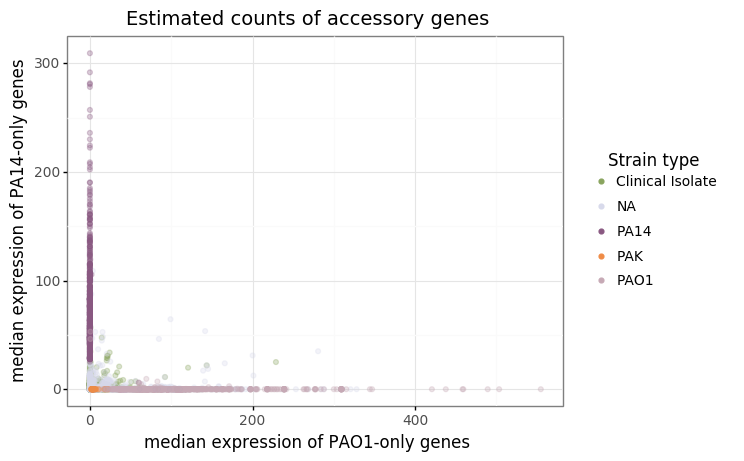

<ggplot: (8745152988777)>


/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: Expression_accessory_genes_all_samples.svg
  warn('Filename: {}'.format(filename))
/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [30]:
# Plot
colors = {
    "Clinical Isolate": "#89A45E",
    "PA14": "#895881",
    "PAK": "#EF8B46",
    "PAO1": "#C6A9B5",
    "NA": "#D8DAEB",
}

fig3 = pn.ggplot(
    pao1_pa14_acc_expression_label,
    pn.aes(x="median acc expression_pao1", y="median acc expression_pa14"),
)
fig3 += pn.geom_point(
    pn.aes(color="Strain type_pao1"),
    alpha=0.3,
)
fig3 += pn.scale_color_manual(values=colors)
fig3 += pn.labs(
    x="median expression of PAO1-only genes",
    y="median expression of PA14-only genes",
    title="Estimated counts of accessory genes",
    width=10,
)
fig3 += pn.theme_bw()
fig3 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=12),
    legend_text=pn.element_text(family="sans-serif", size=10),
    plot_title=pn.element_text(family="sans-serif", size=14),
    axis_text=pn.element_text(family="sans-serif", size=10),
    axis_title=pn.element_text(family="sans-serif", size=12),
)
fig3 += pn.guides(
    colour=pn.guide_legend(title="Strain type", override_aes={"alpha": 1})
)

print(fig3)
fig3.save("Expression_accessory_genes_all_samples.svg", format="svg", dpi=300)

/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


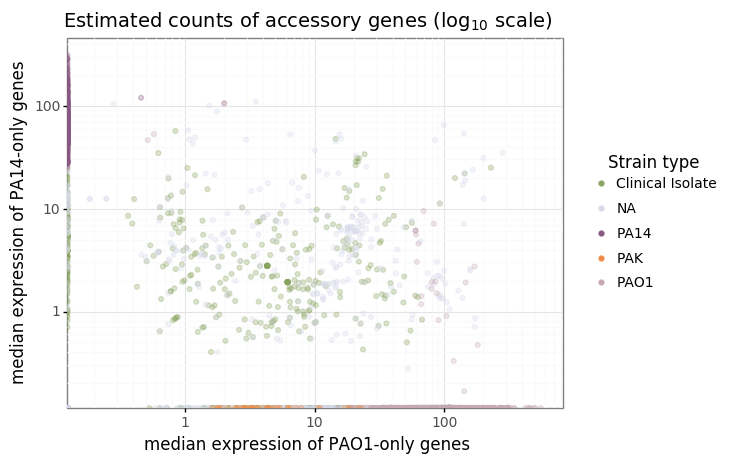

<ggplot: (8745152991829)>


/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: Expression_accessory_genes_all_samples_log10.svg
  warn('Filename: {}'.format(filename))
/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alexandra/anaconda3/envs/make_compendia/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [32]:
# Plot
colors = {
    "Clinical Isolate": "#89A45E",
    "PA14": "#895881",
    "PAK": "#EF8B46",
    "PAO1": "#C6A9B5",
    "NA": "#D8DAEB",
}

fig3a = pn.ggplot(
    pao1_pa14_acc_expression_label,
    pn.aes(x="median acc expression_pao1", y="median acc expression_pa14"),
)
fig3a += pn.geom_point(
    pn.aes(color="Strain type_pao1"),
    alpha=0.3,
)
fig3a += pn.scales.scale_x_log10()
fig3a += pn.scales.scale_y_log10()
fig3a += pn.scale_color_manual(values=colors)
fig3a += pn.labs(
    x="median expression of PAO1-only genes",
    y="median expression of PA14-only genes",
    title=r"Estimated counts of accessory genes (log$_{10}$ scale)",
    width=10,
)
fig3a += pn.theme_bw()
fig3a += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=12),
    legend_text=pn.element_text(family="sans-serif", size=10),
    plot_title=pn.element_text(family="sans-serif", size=14),
    axis_text=pn.element_text(family="sans-serif", size=10),
    axis_title=pn.element_text(family="sans-serif", size=12),
)
fig3a += pn.guides(
    colour=pn.guide_legend(title="Strain type", override_aes={"alpha": 1})
)

print(fig3a)
fig3a.save("Expression_accessory_genes_all_samples_log10.svg", format="svg", dpi=300)

**Takeaway:**
* This is a positive control that PAO1 annotated samples have higher median expression of PAO1-only genes compared to PA14-only genes. And similarly, PA14 annotated samples have higher median expression of PA14-only genes compared to PAO1-only genes. In other words, we expect that PA14-only genes will have either 0 or very low values in PAO1 samples and vice versa.